In [66]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib.pyplot import figure
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from linear_regression_tf import LinearRegressionTF
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import tensorflow as tf
from keras.layers import Input, Embedding, Dense
from keras.models import Model
from sklearn.feature_extraction.text import CountVectorizer
from keras.layers import concatenate, Flatten
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasRegressor

from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from sklearn.manifold import TSNE
from keras import backend as K

# Conversion functions for various columns

In [2]:
def parse_commision(commision):
    if commision.strip() == '':
        return float('nan')
    try:
        return re.match(r'\D*(\d+)\D*', commision).group(1)
    except:
        return float('nan')

In [3]:
def parse_number(value):
    try:
        return float(value)
    except:
        return float('NaN')

In [4]:
def parse_surface(char):
    char = char.replace('.', '')
    char = char.replace(',', '.')
    if 'mp' in char:
        try:
            return float(re.match(r'\D*(\d+\.?\d+)\s*mp.*', char).group(1))
        except:
            pass
    return float('NaN')

In [5]:
def parse_year(char):
    try:
        return int(re.match(r'\D*(\d+)\D*', char).group(1))
    except:
        return float('nan')

In [6]:
def parse_floor(char):
    if 'parter' in char.lower():
        floor = 0
    elif 'etaj' in char.lower():
        try:
            return int(re.match(r'.*etaj\s*(\d+)', char.lower()).group(1))
        except:
            return float('nan')

In [7]:
def map_compartimentalization(comp):
    try:
        return {
        'decomandat': 0,
        'semidecomandat': 1,
        'nedecomandat': 2,
        'circular': 3,
        'vagon': 4
        }[comp]
    except:
        return 5

In [8]:
def map_comfort(comf):
    if comf == 'lux':
        return 4
    return float(comf)

In [9]:
def map_balconies(balc):
    if type(balc) is float:
        return balc
    if 'închise' not in balc:
        return float(balc)
    else:
        return -int(re.match(r'.*(\d+).*închise', balc).group(1))

In [10]:
def map_structure(structure):
    try:
        return {
            'caramida': 1,
            'altele': 0,
            'metal': 2,
            'bca': 3,
            'beton': 4,
            'lemn': 5
        }[structure]
    except Exception as e:
        return float('nan')

In [11]:
def map_type(t):
    if t == 'bloc de apartamente':
        return 1
    elif t == 'casa/vila':
        return 2
    else:
        return 0

In [12]:
def parse_price(price):
    price = price.replace('.', '')
    price = price.replace(',', '')
    try:
        return float(price)
    except:
        return float('nan')

In [13]:
def parse_dist_underground(dist_underground):
    try:
        return int(re.match(r'.*\((\d+).*minut', dist_underground).group(1))
    except:
        return float('nan')

# Constructing the DataFrame

In [14]:
data = []
with open('dataset.txt', 'rt') as fin:
    for line in fin:
        d = json.loads(line)
        if 'An construcţie:' in d:
            d['An construcţie:'] = parse_year(d['An construcţie:'])
        if 'Etaj:' in d:
            d['Etaj:'] = parse_floor(d['Etaj:'])
        if 'Suprafaţă construită:' in d:
            d['Suprafaţă construită:'] = parse_surface(d['Suprafaţă construită:'])
        if 'Suprafaţă utilă totală:' in d:
            d['Suprafaţă utilă totală:'] = parse_surface(d['Suprafaţă utilă totală:'])
        if 'Suprafaţă utilă:' in d:
            d['Suprafaţă utilă:'] = parse_surface(d['Suprafaţă utilă:'])
        del d['currency']
        data.append(d)

In [15]:
df = pd.DataFrame.from_records(data)
df

,An construcţie:,Compartimentare:,Confort:,Etaj:,Nr. balcoane:,Nr. bucătării:,Nr. băi:,Nr. camere:,Nr. garaje:,Nr. locuri parcare:,...,Suprafaţă utilă:,Tip imobil:,commission,description,details,dist_underground,location,poi,price,specifications
0,2017.0,decomandat,lux,4.0,NaN,1,2,4,1,NaN,...,125.00,bloc de apartamente,Comision 0%,"Amplasat in zona premium nord, langa Parcul He...",https://www.imobiliare.ro/vanzare-apartamente/...,1250 m (16 minute),"Bucuresti, zona Herastrau",Localizare şi împrejurimi\nLocalizare\nStreetV...,300.000,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
1,2019.0,decomandat,lux,2.0,2,1,2,3,1,56,...,86.63,bloc de apartamente,Comision 0%,La GLOIRE Parc du LAC este al doilea concept r...,https://www.imobiliare.ro/vanzare-apartamente/...,,"Bucuresti, zona Baneasa",Localizare şi împrejurimi\nLocalizare\nStreetV...,100.999,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
2,2019.0,decomandat,lux,NaN,2,1,2,3,1,56,...,111.97,bloc de apartamente,Comision 0%,La GLOIRE Parc du LAC este al doilea concept r...,https://www.imobiliare.ro/vanzare-apartamente/...,,"Bucuresti, zona Pipera",Localizare şi împrejurimi\nLocalizare\nStreetV...,102.999,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
3,2019.0,semidecomandat,1,1.0,1,1,2,3,NaN,NaN,...,71.85,bloc de apartamente,Comision 0%,Cu aproape 20% din unitati vandute in primele ...,https://www.imobiliare.ro/vanzare-apartamente/...,940 m (12 minute),"Bucuresti, Sector 1, zona Aviatiei",Localizare şi împrejurimi\nLocalizare\nStreetV...,83.200,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
4,2019.0,decomandat,1,1.0,1,1,2,2,NaN,NaN,...,52.61,bloc de apartamente,Comision 0%,Cu aproape 20% din unitati vandute in primele ...,https://www.imobiliare.ro/vanzare-apartamente/...,970 m (12 minute),"Bucuresti, Sector 1, zona Pipera",Localizare şi împrejurimi\nLocalizare\nStreetV...,64.072,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
5,2018.0,decomandat,lux,2.0,1,1,1,2,NaN,1,...,48.00,bloc de apartamente,Comision 0%,"🚌 Transportul asigurat cu microbuze rapide, de...",https://www.imobiliare.ro/vanzare-apartamente/...,940 m (12 minute),"Bucuresti, Sector 6, zona Drumul Taberei",Localizare şi împrejurimi\nLocalizare\nStreetV...,39.900,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
6,2019.0,decomandat,lux,4.0,NaN,1,4,5,NaN,NaN,...,200.00,bloc de apartamente,Comision 0%,Imobiliare Herastrau va prezinta un nou concep...,https://www.imobiliare.ro/vanzare-apartamente/...,1300 m (16 minute),"Bucuresti, zona Soseaua Nordului (Herastrau)",Localizare şi împrejurimi\nLocalizare\nStreetV...,620.000,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
7,2019.0,nedecomandat,lux,1.0,1,1,2,3,NaN,NaN,...,60.00,bloc de apartamente,Comision 0%,Atria Urban Resort este un concept nou de comu...,https://www.imobiliare.ro/vanzare-apartamente/...,,"Bucuresti, Sector 1, zona Bucurestii Noi",Localizare şi împrejurimi\nLocalizare\nStreetV...,69.900,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
8,2019.0,decomandat,lux,1.0,1,1,1,2,NaN,NaN,...,50.00,bloc de apartamente,Comision 0%,Promotie!!!Apartament cu doua camere decomand...,https://www.imobiliare.ro/vanzare-apartamente/...,780 m (10 minute),"Bucuresti, Sector 3, zona 1 Decembrie 1918 (Ti...",Localizare şi împrejurimi\nLocalizare\nStreetV...,40.000,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...
9,2018.0,semidecomandat,lux,2.0,1,1,1,2,NaN,NaN,...,65.42,bloc de apartamente,Comision 0%,O lume a rafinamentului si a luxului! \nImobil...,https://www.imobiliare.ro/vanzare-apartamente/...,1260 m (16 minute),"Bucuresti, zona Herastrau",Localizare şi împrejurimi\nLocalizare\nStreetV...,157.000,\nSpecificaţii\n \nUtilităţi\n \nUtilitati ge...


In [16]:
# Remove features used in later experiments
df['description'] = df['description'] + ' ' + df['specifications']
# del df['description']
# del df['location']
del df['poi']
del df['details']
# del df['dist_underground']
del df['specifications']

In [17]:
df.columns

Index(['An construcţie:', 'Compartimentare:', 'Confort:', 'Etaj:',
       'Nr. balcoane:', 'Nr. bucătării:', 'Nr. băi:', 'Nr. camere:',
       'Nr. garaje:', 'Nr. locuri parcare:', 'Regim înălţime:',
       'Structură rezistenţă:', 'Suprafaţă construită:',
       'Suprafaţă utilă totală:', 'Suprafaţă utilă:', 'Tip imobil:',
       'commission', 'description', 'dist_underground', 'location', 'price'],
      dtype='object')

In [18]:
df.columns = [
    'year', 'compartimentalization', 'comfort', 'floor', 'balconies', 'kitchens',
    'bathrooms', 'rooms', 'garages', 'parking spots', 'height regime',
    'structure', 'built surface', 'total useful surface', 'useful surface',
    'type', 'commission', 'description', 'dist_underground', 'location', 'price'
]

# Data Exploration & Cleaning

### Build Year

In [19]:
df['year'].describe()

count    3944.000000
mean     2005.402637
std        21.766710
min      1900.000000
25%      2000.000000
50%      2018.000000
75%      2018.000000
max      2023.000000
Name: year, dtype: float64

In [20]:
df['year'] = df['year'].fillna(int(df['year'].mean()))

### Compartimentalization style

In [21]:
df['compartimentalization'].value_counts()

decomandat        3000
semidecomandat     864
circular            32
nedecomandat        18
vagon                2
Name: compartimentalization, dtype: int64

In [22]:
df['compartimentalization'] = df['compartimentalization'].apply(map_compartimentalization)
df['compartimentalization'].value_counts()

0    3000
1     864
5      83
3      32
2      18
4       2
Name: compartimentalization, dtype: int64

### Comfort level

In [23]:
df['comfort'].value_counts()

1      2831
lux    1033
2        24
3        13
Name: comfort, dtype: int64

In [24]:
df['comfort'] = df['comfort'].apply(map_comfort)
df['comfort'] = df['comfort'].fillna(int(df['comfort'].mean()))
df['comfort'].value_counts()

1.0    2929
4.0    1033
2.0      24
3.0      13
Name: comfort, dtype: int64

### Apartment floor

In [25]:
df['floor'].value_counts()

1.0     960
2.0     747
3.0     490
4.0     356
5.0     285
6.0     169
7.0     134
8.0     132
9.0      86
10.0     57
11.0     35
13.0     13
12.0      7
14.0      4
15.0      4
25.0      1
20.0      1
17.0      1
Name: floor, dtype: int64

In [26]:
df['floor'] = df['floor'].fillna(df['floor'].median())

### Number of balconies

In [27]:
df['balconies'].value_counts()

1                2292
2                 397
1 (închise)       261
3                  62
2 (închise)        50
2 (1 închise)      26
3 (închise)         8
4                   7
5                   3
3 (1 închise)       2
6                   1
2 (4 închise)       1
4 (2 închise)       1
4 (1 închise)       1
1 (3 închise)       1
1 (2 închise)       1
5 (2 închise)       1
12                  1
Name: balconies, dtype: int64

In [28]:
df['balconies'] = df['balconies'].apply(map_balconies)
df['balconies'] = df['balconies'].fillna(df['balconies'].median())
df['balconies'].value_counts()

 1.0     3175
 2.0      397
-1.0      290
 3.0       62
-2.0       53
-3.0        9
 4.0        7
 5.0        3
-4.0        1
 12.0       1
 6.0        1
Name: balconies, dtype: int64

### Kitchens

In [29]:
df['kitchens'].value_counts()

1    3614
2      19
Name: kitchens, dtype: int64

In [30]:
df['kitchens'] = df['kitchens'].fillna(1)

### Bathrooms

In [31]:
df['bathrooms'].value_counts()

1     2275
2     1415
3      175
4       42
5        7
13       1
11       1
Name: bathrooms, dtype: int64

In [32]:
df['bathrooms'] = df['bathrooms'].fillna(1)

### Rooms

In [33]:
df['rooms'].value_counts()

2     1645
3     1418
1      453
4      386
5       77
6       11
7        5
17       1
33       1
34       1
12       1
Name: rooms, dtype: int64

In [34]:
df['rooms'] = df['rooms'].fillna(2)

### Garages

In [35]:
df['garages'] = df['garages'].fillna(0)

In [36]:
df['garages'].value_counts()

0     3749
1      226
2       18
3        4
30       1
34       1
Name: garages, dtype: int64

### Parking spots

In [37]:
df['parking spots'].value_counts()

1     844
2     107
3      12
56      7
28      4
37      4
4       4
40      2
99      1
50      1
38      1
7       1
34      1
Name: parking spots, dtype: int64

In [38]:
df['parking spots'] = df['parking spots'].fillna(0)

### Structure

In [39]:
df['structure'].value_counts()

beton       3105
caramida     190
altele       132
lemn           1
metal          1
Name: structure, dtype: int64

In [40]:
df['structure'] = df['structure'].fillna('beton')
df['structure'] = df['structure'].apply(map_structure)
df['structure'].value_counts()

4    3675
1     190
0     132
5       1
2       1
Name: structure, dtype: int64

### Height regime

In [41]:
df['height regime'].value_counts()

P+4E          431
P+5E          378
P+3E          322
P+8E          297
P+10E         279
P+6E          207
D+P+5E        140
P+11E         112
P+7E          110
S+P+3E        108
S+P+5E        107
S+P+11E        98
P+9E           98
S+P+4E         86
S+P+8E         86
S+P+10E        83
P+2E           81
S+P+6E         62
S+P+9E         59
S+P+7E         55
D+P+3E         46
D+P+4E         41
P+3E+M         40
D+P+6E         39
P+2E+M         35
D+P+2E+M       23
D+P+8E         23
P+1E           22
S+P+16E        22
D+P+2E         21
             ... 
S+P+24E         3
D+P+1E          3
D+P+10E+M       3
S+D+P+3E        3
S+P+17E         3
D+P+6E+M        2
S+P+1E          2
S+D+P+16E       2
D+P+4E+M        2
S+D+P+13E       2
P+6E+M          2
D+P+8E+M        2
S+P+9E+M        2
P+7E+M          2
P+10E+M         2
P+16E           2
S+P+6E+M        1
S+D+P+9E+M      1
S+D+P+2E+M      1
S+P+M           1
D+P+15E+M       1
S+P+20E         1
D+P+16E         1
D+P+7E+M        1
P+20E     

In [42]:
del df['height regime']

### Surface measurements

In [43]:
df['built surface'] = df['built surface'].fillna(df['built surface'].mean())
df['total useful surface'] = df['total useful surface'].fillna(df['total useful surface'].mean())
df['useful surface'] = df['useful surface'].fillna(df['useful surface'].mean())

### Type

In [44]:
df['type'].value_counts()

bloc de apartamente    3904
casa/vila                81
Name: type, dtype: int64

In [45]:
df['type'] = df['type'].apply(map_type)

### Commission

In [46]:
df['commission'].value_counts()

 Comision 0%     2555
                 1444
Name: commission, dtype: int64

In [47]:
del df['commission']

### Price

In [48]:
df['price'][:5]

0    300.000
1    100.999
2    102.999
3     83.200
4     64.072
Name: price, dtype: object

In [49]:
df['price'] = df['price'].apply(parse_price)

### Description text mining

In [50]:
print('Number of samples without description:', len(list(filter(lambda e: len(e) < 2, df['description']))))

Number of samples without description: 0


In [51]:
vectorizer = TfidfVectorizer(min_df=.2, max_df=0.8)

In [52]:
vectorizer.fit(df['description'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=0.2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [53]:
len(vectorizer.vocabulary_)

112

In [54]:
vectorizer.vocabulary_

{'zona': 111,
 'parcul': 67,
 'rezidential': 80,
 'se': 83,
 'pe': 70,
 'va': 104,
 'fi': 40,
 'sunt': 91,
 'apartamente': 5,
 'pentru': 71,
 'are': 8,
 'suprafata': 92,
 'din': 30,
 'care': 16,
 'terasa': 95,
 'este': 34,
 'bucatarie': 10,
 'proprie': 76,
 'spatii': 87,
 'catv': 17,
 'telefon': 94,
 'centrala': 20,
 'calorifere': 14,
 'prin': 75,
 'climatizare': 21,
 'aer': 3,
 'conditionat': 25,
 'acces': 1,
 'internet': 48,
 'cablu': 12,
 'metal': 56,
 'izolatii': 50,
 'termice': 96,
 'exterior': 36,
 'gresie': 44,
 'usi': 102,
 'lemn': 52,
 'vopsea': 108,
 'lavabila': 51,
 'faianta': 38,
 'contorizare': 28,
 'apometre': 7,
 'contor': 27,
 'dotari': 33,
 'curte': 29,
 'lift': 53,
 'servicii': 84,
 'supraveghere': 93,
 'video': 107,
 'iluminat': 45,
 'stradal': 90,
 'mijloace': 58,
 'transport': 99,
 'comun': 24,
 'vecinătăţi': 106,
 'metrou': 57,
 'disponibilitate': 31,
 'proprietate': 77,
 'face': 37,
 'foarte': 42,
 'calitate': 13,
 'fibra': 41,
 'optica': 65,
 'wireless': 110,
 '

### Distance to underground

In [55]:
df['dist_underground'] = df['dist_underground'].apply(parse_dist_underground)

In [56]:
df['dist_underground'].describe()

count    2659.000000
mean        9.832644
std         5.967889
min         1.000000
25%         5.000000
50%         9.000000
75%        14.000000
max        25.000000
Name: dist_underground, dtype: float64

In [57]:
df['dist_underground'] = df['dist_underground'].fillna(int(np.mean(df['dist_underground'])))

### Check for any other NaNs 

In [58]:
for col in df.columns:
    print(col, 'has nans:', df[col].isnull().any())
    if col not in ['description', 'location']:
        df[col] = pd.to_numeric(df[col])

year has nans: False
compartimentalization has nans: False
comfort has nans: False
floor has nans: False
balconies has nans: False
kitchens has nans: False
bathrooms has nans: False
rooms has nans: False
garages has nans: False
parking spots has nans: False
structure has nans: False
built surface has nans: False
total useful surface has nans: False
useful surface has nans: False
type has nans: False
description has nans: False
dist_underground has nans: False
location has nans: False
price has nans: True


In [59]:
print('Number of items without pricing:', sum(df['price'].isnull()))

Number of items without pricing: 11


In [60]:
# Since we can't predict anything without the price, we drop any nan rows
df = df.dropna()

## Feature correlations

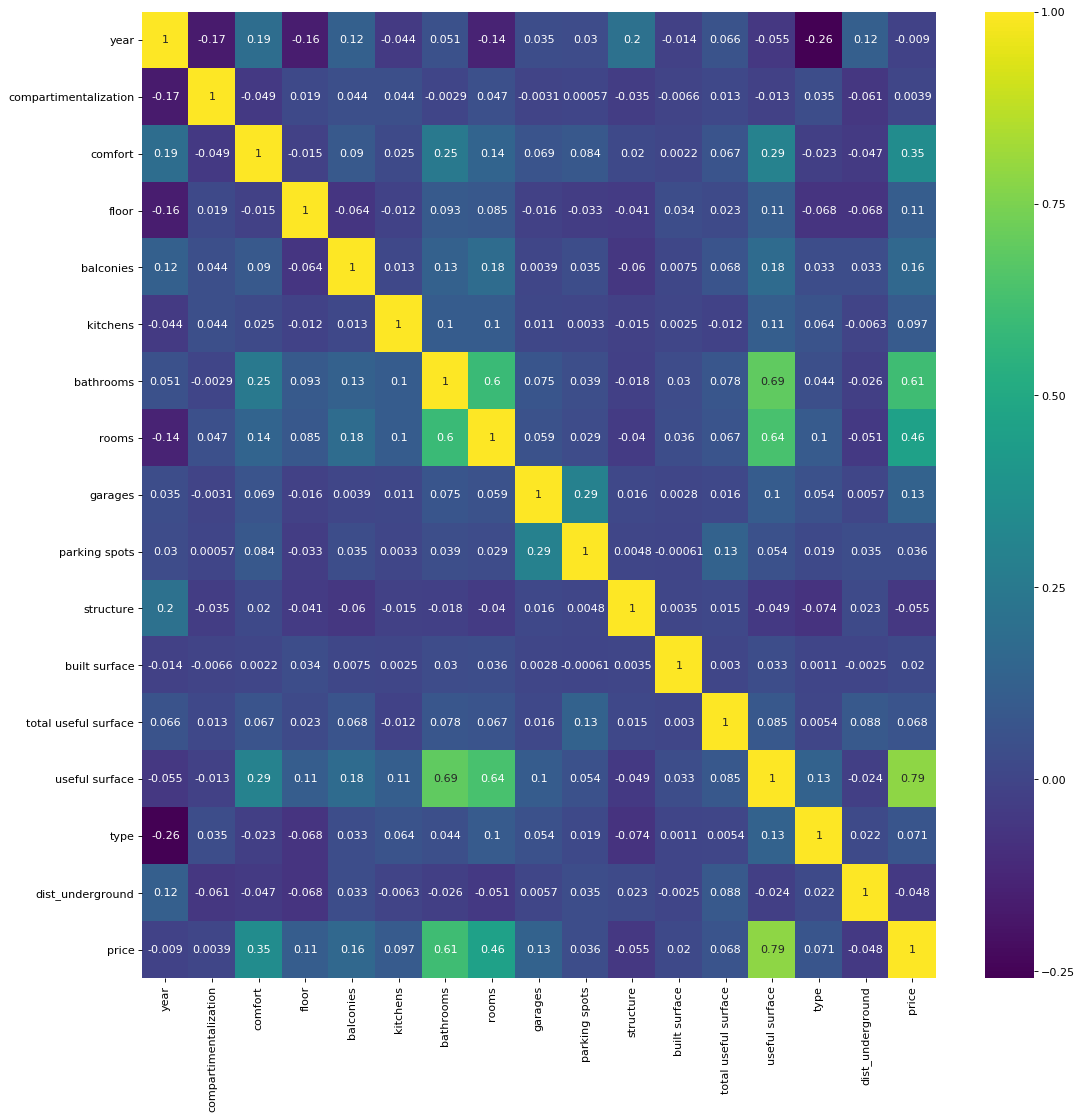

In [67]:
figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(df.corr(), cmap=plt.cm.viridis, annot=True)
plt.show()

# Model creation

In [68]:
# We select only variables linearly correlated with the price|
independent_variables = ['comfort', 'bathrooms', 'rooms', 'useful surface']

In [69]:
# Build and evaluate a model using 5-fold CV
X = np.array(df[independent_variables])
y = np.array(df['price'])

vectorizer = TfidfVectorizer(min_df=.2, max_df=0.8)
vectorizer.fit(df['description'])
text_data = vectorizer.transform(df['description'])

X = np.hstack([X, text_data.todense()])
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

In [70]:
locations = list(df['location'])

encoder = LabelEncoder()
encoder.fit(locations)
locations = encoder.transform(locations)

In [71]:
print('Vocabulary size:', len(encoder.classes_))
embedding_size = int(np.ceil(328 ** (1/4)))
embedding_size

Vocabulary size: 354


5

In [67]:
mined_features = Input(shape=X.shape[1:], name='mined_features_input')
location = Input(shape=(1,), name='location_input')

embedded_location = Embedding(input_dim=len(encoder.classes_),
                              output_dim=embedding_size,
                              name='location_embedding')(location)
embedded_location = Flatten()(embedded_location)
x = concatenate([mined_features, embedded_location])
out = Dense(1, name='output')(x)
model = Model(inputs=[mined_features, location], outputs=out)
model.compile(optimizer=Adam(lr=27.0), loss='mean_squared_error')

In [68]:
def schedule(epoch, lr):
    if epoch in [25, 45, 75, 100, 125, 150, 175]:
        return lr / 3.0
    return lr
scheduler = LearningRateScheduler(schedule=schedule)

In [69]:
history = model.fit([X, locations], y, epochs=200, callbacks=[scheduler])

Epoch 1/200
3988/3988 [==============================] - 0s 78us/step - loss: 13271822131.6108
Epoch 2/200
3988/3988 [==============================] - 0s 44us/step - loss: 8604994124.5176
Epoch 3/200
3988/3988 [==============================] - 0s 51us/step - loss: 7349564234.9769
Epoch 4/200
3988/3988 [==============================] - 0s 45us/step - loss: 7227299557.0391
Epoch 5/200
3988/3988 [==============================] - 0s 35us/step - loss: 6829298188.3250
Epoch 6/200
3988/3988 [==============================] - 0s 35us/step - loss: 6365721511.1575
Epoch 7/200
3988/3988 [==============================] - 0s 35us/step - loss: 6289694663.5105
Epoch 8/200
3988/3988 [==============================] - 0s 44us/step - loss: 6474108788.3811
Epoch 9/200
3988/3988 [==============================] - 0s 44us/step - loss: 6230799891.5145
Epoch 10/200
3988/3988 [==============================] - 0s 44us/step - loss: 5742462883.0491
Epoch 11/200
3988/3988 [==============================] - 

3988/3988 [==============================] - 0s 43us/step - loss: 3330913071.6309
Epoch 173/200
3988/3988 [==============================] - 0s 36us/step - loss: 3330995816.8907
Epoch 174/200
3988/3988 [==============================] - 0s 30us/step - loss: 3330906276.9107
Epoch 175/200
3988/3988 [==============================] - 0s 30us/step - loss: 3330846718.4594
Epoch 176/200
3988/3988 [==============================] - 0s 34us/step - loss: 3329565103.8877
Epoch 177/200
3988/3988 [==============================] - 0s 38us/step - loss: 3329556727.0130
Epoch 178/200
3988/3988 [==============================] - 0s 38us/step - loss: 3329431245.2558
Epoch 179/200
3988/3988 [==============================] - 0s 52us/step - loss: 3329408351.3902
Epoch 180/200
3988/3988 [==============================] - 0s 46us/step - loss: 3329558707.4824
Epoch 181/200
3988/3988 [==============================] - 0s 39us/step - loss: 3329401808.9468
Epoch 182/200
3988/3988 [=============================

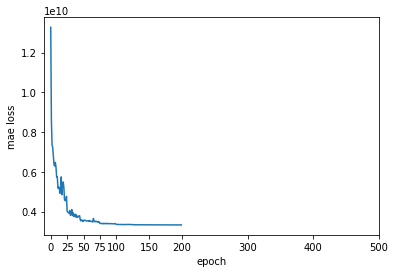

In [70]:
plt.plot(history.epoch, history.history['loss'])
plt.xlabel('epoch')
plt.xticks([0, 25, 50, 75, 100, 150, 200, 300, 400, 500])
plt.ylabel('mae loss')
plt.show()

In [71]:
np.sqrt(mean_squared_error(model.predict([X, locations]), y))

57694.4181744064

In [72]:
def make_model():
    mined_features = Input(shape=X.shape[1:], name='mined_features_input')
    location = Input(shape=(1,), name='location_input')

    embedded_location = Embedding(input_dim=len(encoder.classes_),
                                  output_dim=embedding_size,
                                  name='location_embedding')(location)
    embedded_location = Flatten()(embedded_location)
    x = concatenate([mined_features, embedded_location])
    out = Dense(1, name='output')(x)
    model = Model(inputs=[mined_features, location], outputs=out)
    model.compile(optimizer=Adam(lr=27.0), loss='mean_squared_error')
    return model

In [74]:
# Build and evaluate a model using 5-fold CV
X = np.array(df[independent_variables])
y = np.array(df['price'])

vectorizer = TfidfVectorizer(min_df=.2, max_df=0.8)
vectorizer.fit(df['description'])
text_data = vectorizer.transform(df['description'])

X = np.hstack([X, text_data.todense()])
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

kfold = KFold(n_splits=5)

for split, (train_indices, test_indices) in enumerate(kfold.split(range(X.shape[0]))):
    train_X, train_y = X[train_indices], y[train_indices]
    test_X, test_y = X[test_indices], y[test_indices]

    model = make_model()
    locations = list(df['location'])
    train_locations = encoder.transform([locations[i] for i in train_indices])
    test_locations = encoder.transform([locations[i] for i in test_indices])
    
    model.fit([train_X, train_locations], train_y,
              validation_data=([test_X, test_locations], test_y),
              epochs=200, callbacks=[scheduler, EarlyStopping(patience=30)],
              verbose=False)
    
    y_pred = model.predict([test_X, test_locations])
    score = np.sqrt(mean_squared_error(test_y, y_pred))  # RMSE
    print('[Split %d] Score: %f' % (split, score))

[Split 0] Score: 90648.297055
[Split 1] Score: 71620.758989
[Split 2] Score: 55948.312553
[Split 3] Score: 73685.321824
[Split 4] Score: 61412.349633


In [75]:
embedding_layer = model.layers[1]

In [105]:
get_embedding_output = K.function([model.layers[1].input],
                                  [model.layers[1].output])
embeddings = get_embedding_output([encoder.transform(locations)])[0]

In [106]:
embeddings = np.unique(embeddings, axis=0)
embeddings.shape

(354, 5)

In [108]:
tsne = TSNE()

In [109]:
projected_embeddings = tsne.fit_transform(embeddings)

In [110]:
projected_embeddings.shape

(354, 2)

In [111]:
embeddings_data = pd.DataFrame.from_records(
    list(zip(projected_embeddings[:,0], projected_embeddings[:,1], locations))
)
embeddings_data.columns = ['x', 'y', 'name']

In [112]:
embeddings_data.head()

,x,y,name
0,-31.988050,16.076721,"Bucuresti, zona Herastrau"
1,-30.118694,14.456391,"Bucuresti, zona Baneasa"
2,-29.049095,19.317768,"Bucuresti, zona Pipera"
3,-28.744555,17.532057,"Bucuresti, Sector 1, zona Aviatiei"
4,-29.665077,16.233389,"Bucuresti, Sector 1, zona Pipera"


In [113]:
embeddings_data = embeddings_data.drop_duplicates()
embeddings_data.shape

(354, 3)

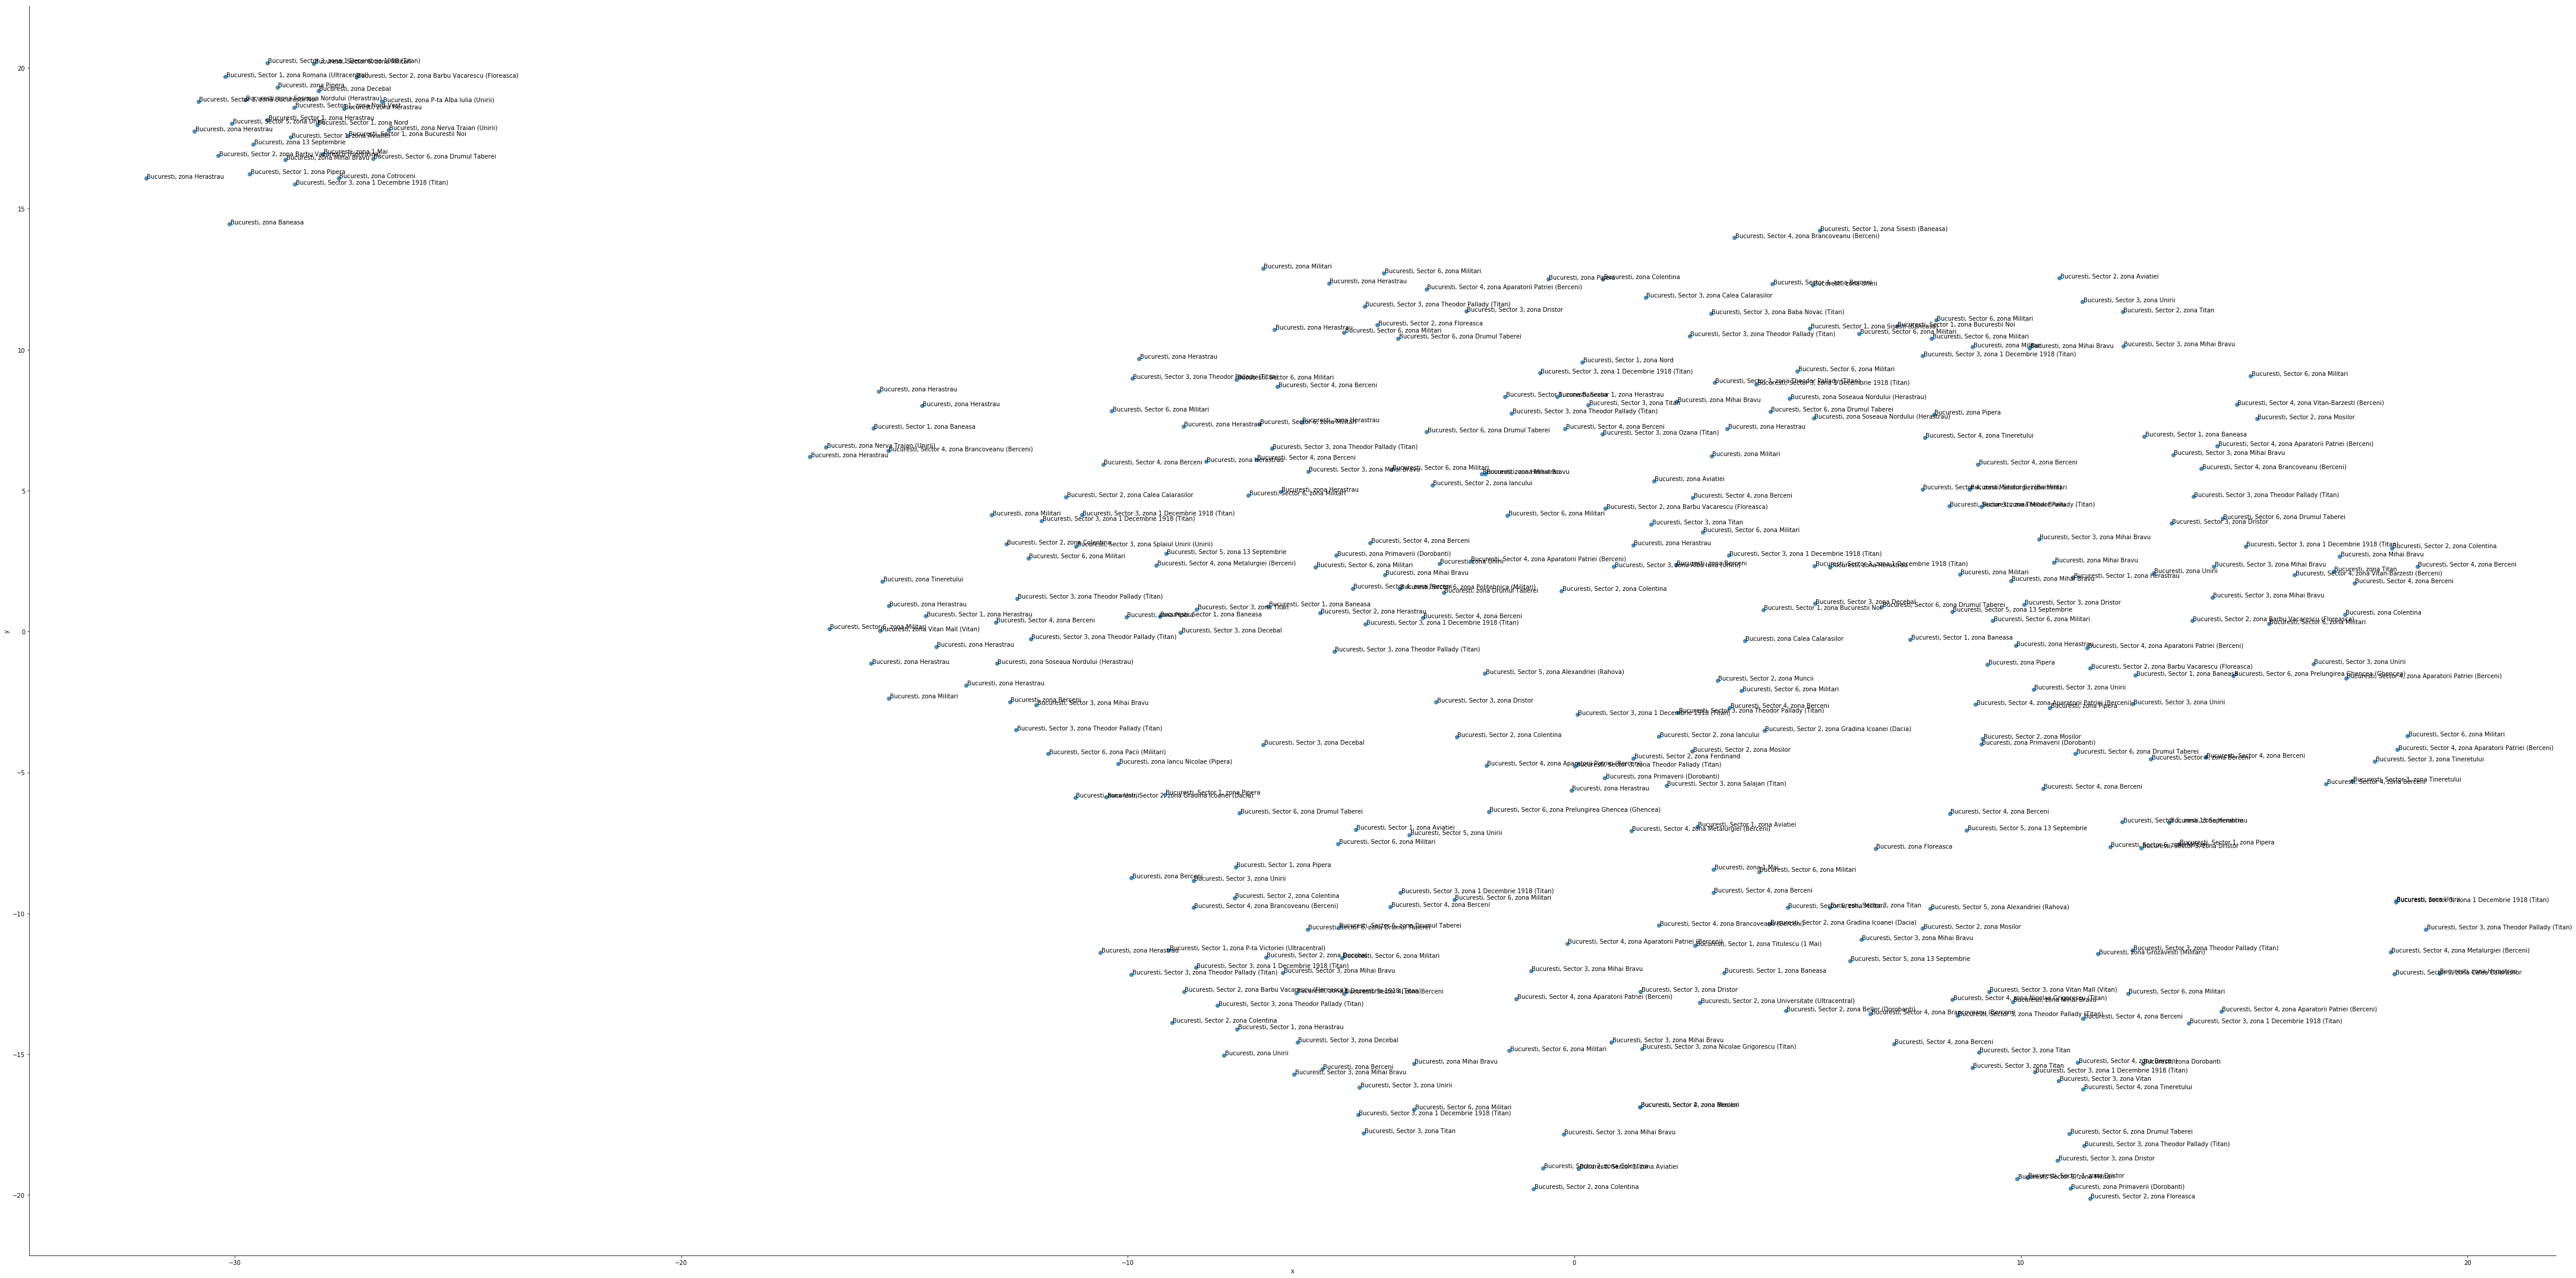

In [115]:
sns.lmplot('x', 'y', data=embeddings_data, fit_reg=False, height=30, aspect=2)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'name': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'] + 0.01, str(point['name']))

label_point(embeddings_data.x, embeddings_data.y, embeddings_data.name, plt.gca())
plt.savefig('location_embeddings.png')

### Try to train just the embeddings

In [104]:
location = Input(shape=(1,), name='location_input')
embedded_location = Embedding(input_dim=len(encoder.classes_),
                              output_dim=embedding_size,
                              name='location_embedding')(location)
out = Dense(1, name='output')(Flatten()(embedded_location))
model = Model(inputs=location, outputs=out)
model.compile(optimizer=Adam(lr=3.0), loss='mean_squared_error')

In [105]:
def schedule(epoch, lr):
    if epoch in [750, 1500]:
        return lr / 3.0
    return lr
scheduler = LearningRateScheduler(schedule=schedule)

In [106]:
history = model.fit(locations, y, epochs=2000)

Epoch 1/2000
3988/3988 [==============================] - 0s 124us/step - loss: 19550914389.5045
Epoch 2/2000
3988/3988 [==============================] - 0s 51us/step - loss: 9999880881.6851
Epoch 3/2000
3988/3988 [==============================] - 0s 56us/step - loss: 8611928797.3360
Epoch 4/2000
3988/3988 [==============================] - 0s 50us/step - loss: 8244784114.6479
Epoch 5/2000
3988/3988 [==============================] - 0s 55us/step - loss: 8110132095.7432
Epoch 6/2000
3988/3988 [==============================] - 0s 53us/step - loss: 7993396063.2618
Epoch 7/2000
3988/3988 [==============================] - 0s 46us/step - loss: 8018424033.7011
Epoch 8/2000
3988/3988 [==============================] - 0s 63us/step - loss: 7929378566.1625
Epoch 9/2000
3988/3988 [==============================] - 0s 54us/step - loss: 7931762570.9127
Epoch 10/2000
3988/3988 [==============================] - 0s 54us/step - loss: 7844280133.5848
Epoch 11/2000
3988/3988 [======================

3988/3988 [==============================] - 0s 56us/step - loss: 7629884095.5507
Epoch 87/2000
3988/3988 [==============================] - 0s 51us/step - loss: 7618305940.1565
Epoch 88/2000
3988/3988 [==============================] - 0s 51us/step - loss: 7637135875.8516
Epoch 89/2000
3988/3988 [==============================] - 0s 48us/step - loss: 7619552433.8134
Epoch 90/2000
3988/3988 [==============================] - 0s 50us/step - loss: 7634864459.7472
Epoch 91/2000
3988/3988 [==============================] - 0s 67us/step - loss: 7685641232.6901
Epoch 92/2000
3988/3988 [==============================] - 0s 64us/step - loss: 7606711255.4303
Epoch 93/2000
3988/3988 [==============================] - 0s 58us/step - loss: 7669923992.0080
Epoch 94/2000
3988/3988 [==============================] - 0s 59us/step - loss: 7698708457.4042
Epoch 95/2000
3988/3988 [==============================] - 0s 58us/step - loss: 7651208965.0712
Epoch 96/2000
3988/3988 [=============================

3988/3988 [==============================] - 0s 114us/step - loss: 7598988393.7894
Epoch 171/2000
3988/3988 [==============================] - 0s 63us/step - loss: 7606412185.8054
Epoch 172/2000
3988/3988 [==============================] - 0s 73us/step - loss: 7585304632.4895
Epoch 173/2000
3988/3988 [==============================] - 1s 137us/step - loss: 7633374528.4493
Epoch 174/2000
3988/3988 [==============================] - 0s 69us/step - loss: 7610847678.0100
Epoch 175/2000
3988/3988 [==============================] - 0s 77us/step - loss: 7589966442.6881
Epoch 176/2000
3988/3988 [==============================] - 0s 99us/step - loss: 7561672470.3390
Epoch 177/2000
3988/3988 [==============================] - 1s 166us/step - loss: 7598560916.4132
Epoch 178/2000
3988/3988 [==============================] - 0s 97us/step - loss: 7597252915.9960
Epoch 179/2000
3988/3988 [==============================] - 0s 54us/step - loss: 7560235264.7703
Epoch 180/2000
3988/3988 [================

3988/3988 [==============================] - 0s 64us/step - loss: 7524151627.2337
Epoch 255/2000
3988/3988 [==============================] - 0s 69us/step - loss: 7621825118.4915
Epoch 256/2000
3988/3988 [==============================] - 0s 71us/step - loss: 7579120026.0622
Epoch 257/2000
3988/3988 [==============================] - 0s 77us/step - loss: 7561017449.0191
Epoch 258/2000
3988/3988 [==============================] - 0s 74us/step - loss: 7511505260.6138
Epoch 259/2000
3988/3988 [==============================] - 0s 71us/step - loss: 7521471865.4524
Epoch 260/2000
3988/3988 [==============================] - 0s 71us/step - loss: 7529153185.7653
Epoch 261/2000
3988/3988 [==============================] - 0s 55us/step - loss: 7586635416.5216
Epoch 262/2000
3988/3988 [==============================] - 0s 42us/step - loss: 7546509266.0381
Epoch 263/2000
3988/3988 [==============================] - 0s 41us/step - loss: 7591353880.3932
Epoch 264/2000
3988/3988 [===================

3988/3988 [==============================] - 0s 60us/step - loss: 7521595054.6038
Epoch 339/2000
3988/3988 [==============================] - 0s 50us/step - loss: 7617302406.2909
Epoch 340/2000
3988/3988 [==============================] - 0s 48us/step - loss: 7621351103.5507
Epoch 341/2000
3988/3988 [==============================] - 0s 49us/step - loss: 7539197044.5737
Epoch 342/2000
3988/3988 [==============================] - 0s 52us/step - loss: 7581829016.7783
Epoch 343/2000
3988/3988 [==============================] - 0s 51us/step - loss: 7509278841.4524
Epoch 344/2000
3988/3988 [==============================] - 0s 59us/step - loss: 7616713890.7924
Epoch 345/2000
3988/3988 [==============================] - 0s 51us/step - loss: 7576477786.8325
Epoch 346/2000
3988/3988 [==============================] - 0s 50us/step - loss: 7518557462.8526
Epoch 347/2000
3988/3988 [==============================] - 0s 52us/step - loss: 7539625180.8225
Epoch 348/2000
3988/3988 [===================

3988/3988 [==============================] - 0s 77us/step - loss: 7660859677.5286
Epoch 423/2000
3988/3988 [==============================] - 0s 53us/step - loss: 7563725477.8736
Epoch 424/2000
3988/3988 [==============================] - 0s 59us/step - loss: 7497918109.4002
Epoch 425/2000
3988/3988 [==============================] - 0s 87us/step - loss: 7519108024.6179
Epoch 426/2000
3988/3988 [==============================] - 0s 106us/step - loss: 7508616648.4092
Epoch 427/2000
3988/3988 [==============================] - 0s 74us/step - loss: 7502710488.2006
Epoch 428/2000
3988/3988 [==============================] - 0s 57us/step - loss: 7551037082.5115
Epoch 429/2000
3988/3988 [==============================] - 0s 86us/step - loss: 7593289949.3360
Epoch 430/2000
3988/3988 [==============================] - 0s 44us/step - loss: 7529168520.6018
Epoch 431/2000
3988/3988 [==============================] - 0s 74us/step - loss: 7556488709.0070
Epoch 432/2000
3988/3988 [==================

3988/3988 [==============================] - 0s 47us/step - loss: 7547722248.7302
Epoch 507/2000
3988/3988 [==============================] - 0s 44us/step - loss: 7474864635.8917
Epoch 508/2000
3988/3988 [==============================] - 0s 45us/step - loss: 7499045028.8465
Epoch 509/2000
3988/3988 [==============================] - 0s 48us/step - loss: 7536892971.6510
Epoch 510/2000
3988/3988 [==============================] - 0s 49us/step - loss: 7556028405.9860
Epoch 511/2000
3988/3988 [==============================] - 0s 47us/step - loss: 7543917943.3982
Epoch 512/2000
3988/3988 [==============================] - 0s 50us/step - loss: 7530082392.3290
Epoch 513/2000
3988/3988 [==============================] - 0s 47us/step - loss: 7559663148.1645
Epoch 514/2000
3988/3988 [==============================] - 0s 49us/step - loss: 7498341115.6349
Epoch 515/2000
3988/3988 [==============================] - 0s 49us/step - loss: 7543376283.0893
Epoch 516/2000
3988/3988 [===================

3988/3988 [==============================] - 0s 60us/step - loss: 7521463680.6419
Epoch 591/2000
3988/3988 [==============================] - 0s 55us/step - loss: 7478065759.0050
Epoch 592/2000
3988/3988 [==============================] - 0s 51us/step - loss: 7498304770.1825
Epoch 593/2000
3988/3988 [==============================] - 0s 53us/step - loss: 7483839874.6961
Epoch 594/2000
3988/3988 [==============================] - 0s 47us/step - loss: 7462448946.3270
Epoch 595/2000
3988/3988 [==============================] - 0s 54us/step - loss: 7515040392.0883
Epoch 596/2000
3988/3988 [==============================] - 0s 49us/step - loss: 7509317753.7091
Epoch 597/2000
3988/3988 [==============================] - 0s 54us/step - loss: 7480794121.7573
Epoch 598/2000
3988/3988 [==============================] - 0s 50us/step - loss: 7500777295.8556
Epoch 599/2000
3988/3988 [==============================] - 0s 49us/step - loss: 7498650478.6680
Epoch 600/2000
3988/3988 [===================

3988/3988 [==============================] - 0s 61us/step - loss: 7488165298.9689
Epoch 675/2000
3988/3988 [==============================] - 0s 50us/step - loss: 7474188260.7823
Epoch 676/2000
3988/3988 [==============================] - 0s 53us/step - loss: 7483193563.7954
Epoch 677/2000
3988/3988 [==============================] - 0s 51us/step - loss: 7587515332.9428
Epoch 678/2000
3988/3988 [==============================] - 0s 48us/step - loss: 7516746393.5486
Epoch 679/2000
3988/3988 [==============================] - 0s 44us/step - loss: 7513025269.2156
Epoch 680/2000
3988/3988 [==============================] - 0s 53us/step - loss: 7488754713.5486
Epoch 681/2000
3988/3988 [==============================] - 0s 51us/step - loss: 7489787863.6871
Epoch 682/2000
3988/3988 [==============================] - 0s 51us/step - loss: 7474008339.0010
Epoch 683/2000
3988/3988 [==============================] - 0s 55us/step - loss: 7530311445.3119
Epoch 684/2000
3988/3988 [===================

3988/3988 [==============================] - 0s 65us/step - loss: 7464541223.7994
Epoch 759/2000
3988/3988 [==============================] - 0s 58us/step - loss: 7475693336.9067
Epoch 760/2000
3988/3988 [==============================] - 0s 57us/step - loss: 7550060422.1625
Epoch 761/2000
3988/3988 [==============================] - 0s 57us/step - loss: 7514193631.3902
Epoch 762/2000
3988/3988 [==============================] - 0s 60us/step - loss: 7467552878.4112
Epoch 763/2000
3988/3988 [==============================] - 0s 54us/step - loss: 7506898365.7533
Epoch 764/2000
3988/3988 [==============================] - 0s 56us/step - loss: 7494404757.0552
Epoch 765/2000
3988/3988 [==============================] - 0s 56us/step - loss: 7478452941.1595
Epoch 766/2000
3988/3988 [==============================] - 0s 62us/step - loss: 7436719671.3340
Epoch 767/2000
3988/3988 [==============================] - 0s 54us/step - loss: 7533511053.9940
Epoch 768/2000
3988/3988 [===================

3988/3988 [==============================] - 0s 57us/step - loss: 7508010219.2016
Epoch 843/2000
3988/3988 [==============================] - 0s 50us/step - loss: 7503816201.2437
Epoch 844/2000
3988/3988 [==============================] - 0s 58us/step - loss: 7443725582.8927
Epoch 845/2000
3988/3988 [==============================] - 0s 58us/step - loss: 7491450318.1866
Epoch 846/2000
3988/3988 [==============================] - 0s 48us/step - loss: 7493457903.5667
Epoch 847/2000
3988/3988 [==============================] - 0s 53us/step - loss: 7494286140.3410
Epoch 848/2000
3988/3988 [==============================] - 0s 50us/step - loss: 7484502843.5707
Epoch 849/2000
3988/3988 [==============================] - 0s 46us/step - loss: 7507610609.7492
Epoch 850/2000
3988/3988 [==============================] - 0s 56us/step - loss: 7448485913.6770
Epoch 851/2000
3988/3988 [==============================] - 0s 48us/step - loss: 7457272788.3490
Epoch 852/2000
3988/3988 [===================

3988/3988 [==============================] - 0s 56us/step - loss: 7485123046.5797
Epoch 927/2000
3988/3988 [==============================] - 0s 53us/step - loss: 7443293473.6369
Epoch 928/2000
3988/3988 [==============================] - 0s 54us/step - loss: 7524159863.6550
Epoch 929/2000
3988/3988 [==============================] - 0s 49us/step - loss: 7459024760.6820
Epoch 930/2000
3988/3988 [==============================] - 0s 52us/step - loss: 7500493193.6289
Epoch 931/2000
3988/3988 [==============================] - 0s 50us/step - loss: 7449522639.2136
Epoch 932/2000
3988/3988 [==============================] - 0s 52us/step - loss: 7520490188.3892
Epoch 933/2000
3988/3988 [==============================] - 0s 47us/step - loss: 7492464974.3149
Epoch 934/2000
3988/3988 [==============================] - 0s 50us/step - loss: 7477119532.1645
Epoch 935/2000
3988/3988 [==============================] - 0s 55us/step - loss: 7501830459.8275
Epoch 936/2000
3988/3988 [===================

3988/3988 [==============================] - 0s 51us/step - loss: 7473446793.3721
Epoch 1011/2000
3988/3988 [==============================] - 0s 52us/step - loss: 7497325719.4945
Epoch 1012/2000
3988/3988 [==============================] - 0s 56us/step - loss: 7486448668.1163
Epoch 1013/2000
3988/3988 [==============================] - 0s 50us/step - loss: 7461281058.1505
Epoch 1014/2000
3988/3988 [==============================] - 0s 46us/step - loss: 7465827067.5065
Epoch 1015/2000
3988/3988 [==============================] - 0s 49us/step - loss: 7445572163.0171
Epoch 1016/2000
3988/3988 [==============================] - 0s 51us/step - loss: 7489116568.0080
Epoch 1017/2000
3988/3988 [==============================] - 0s 48us/step - loss: 7482422020.8786
Epoch 1018/2000
3988/3988 [==============================] - 0s 55us/step - loss: 7489212271.1815
Epoch 1019/2000
3988/3988 [==============================] - 0s 50us/step - loss: 7571990809.4203
Epoch 1020/2000
3988/3988 [=========

3988/3988 [==============================] - 0s 69us/step - loss: 7498280830.0742
Epoch 1094/2000
3988/3988 [==============================] - 0s 55us/step - loss: 7468148032.3210
Epoch 1095/2000
3988/3988 [==============================] - 0s 57us/step - loss: 7503812642.4072
Epoch 1096/2000
3988/3988 [==============================] - 0s 54us/step - loss: 7482858982.8365
Epoch 1097/2000
3988/3988 [==============================] - 0s 48us/step - loss: 7467158369.8295
Epoch 1098/2000
3988/3988 [==============================] - 0s 52us/step - loss: 7465906449.3320
Epoch 1099/2000
3988/3988 [==============================] - 0s 72us/step - loss: 7488804045.6730
Epoch 1100/2000
3988/3988 [==============================] - 0s 70us/step - loss: 7478704418.4072
Epoch 1101/2000
3988/3988 [==============================] - 0s 80us/step - loss: 7500568297.6610
Epoch 1102/2000
3988/3988 [==============================] - 0s 61us/step - loss: 7457453102.7322
Epoch 1103/2000
3988/3988 [=========

3988/3988 [==============================] - 0s 66us/step - loss: 7452247384.5858
Epoch 1177/2000
3988/3988 [==============================] - 0s 85us/step - loss: 7491978614.8847
Epoch 1178/2000
3988/3988 [==============================] - 0s 75us/step - loss: 7515942602.3350
Epoch 1179/2000
3988/3988 [==============================] - 1s 170us/step - loss: 7517501858.0221
Epoch 1180/2000
3988/3988 [==============================] - 0s 110us/step - loss: 7509140167.8957
Epoch 1181/2000
3988/3988 [==============================] - 1s 142us/step - loss: 7467400640.1926
Epoch 1182/2000
3988/3988 [==============================] - 0s 80us/step - loss: 7453775470.6680
Epoch 1183/2000
3988/3988 [==============================] - 0s 72us/step - loss: 7578051190.5958
Epoch 1184/2000
3988/3988 [==============================] - 0s 68us/step - loss: 7524653845.0552
Epoch 1185/2000
3988/3988 [==============================] - 0s 117us/step - loss: 7490196106.6560
Epoch 1186/2000
3988/3988 [=====

3988/3988 [==============================] - 0s 38us/step - loss: 7579432285.2076
Epoch 1260/2000
3988/3988 [==============================] - 0s 37us/step - loss: 7458234288.6580
Epoch 1261/2000
3988/3988 [==============================] - 0s 42us/step - loss: 7501927188.2849
Epoch 1262/2000
3988/3988 [==============================] - 0s 40us/step - loss: 7498489638.2588
Epoch 1263/2000
3988/3988 [==============================] - 0s 39us/step - loss: 7462116837.2959
Epoch 1264/2000
3988/3988 [==============================] - 0s 45us/step - loss: 7542014872.7783
Epoch 1265/2000
3988/3988 [==============================] - 0s 40us/step - loss: 7457304374.6921
Epoch 1266/2000
3988/3988 [==============================] - 0s 38us/step - loss: 7487827079.1896
Epoch 1267/2000
3988/3988 [==============================] - 0s 40us/step - loss: 7491243269.9057
Epoch 1268/2000
3988/3988 [==============================] - 0s 36us/step - loss: 7439358257.5567
Epoch 1269/2000
3988/3988 [=========

3988/3988 [==============================] - 0s 83us/step - loss: 7467264643.7232
Epoch 1343/2000
3988/3988 [==============================] - 0s 68us/step - loss: 7480671159.5908
Epoch 1344/2000
3988/3988 [==============================] - 0s 71us/step - loss: 7474507580.3410
Epoch 1345/2000
3988/3988 [==============================] - 0s 92us/step - loss: 7462783139.8195
Epoch 1346/2000
3988/3988 [==============================] - 0s 76us/step - loss: 7461252788.2528
Epoch 1347/2000
3988/3988 [==============================] - 0s 61us/step - loss: 7471511212.0361
Epoch 1348/2000
3988/3988 [==============================] - 0s 44us/step - loss: 7490924947.6429
Epoch 1349/2000
3988/3988 [==============================] - 0s 63us/step - loss: 7467159035.3781
Epoch 1350/2000
3988/3988 [==============================] - 0s 50us/step - loss: 7409428401.4283
Epoch 1351/2000
3988/3988 [==============================] - 0s 50us/step - loss: 7489376703.2939
Epoch 1352/2000
3988/3988 [=========

3988/3988 [==============================] - 0s 38us/step - loss: 7491202570.5276
Epoch 1426/2000
3988/3988 [==============================] - 0s 38us/step - loss: 7481931531.5547
Epoch 1427/2000
3988/3988 [==============================] - 0s 44us/step - loss: 7477241271.5908
Epoch 1428/2000
3988/3988 [==============================] - 0s 44us/step - loss: 7539155026.1665
Epoch 1429/2000
3988/3988 [==============================] - 0s 41us/step - loss: 7439647286.9488
Epoch 1430/2000
3988/3988 [==============================] - 0s 40us/step - loss: 7487522994.9689
Epoch 1431/2000
3988/3988 [==============================] - 0s 36us/step - loss: 7482235814.1304
Epoch 1432/2000
3988/3988 [==============================] - 0s 71us/step - loss: 7474888714.2708
Epoch 1433/2000
3988/3988 [==============================] - 0s 87us/step - loss: 7482263731.2257: 0s - loss: 59469
Epoch 1434/2000
3988/3988 [==============================] - 0s 47us/step - loss: 7480190164.6058
Epoch 1435/2000
39

3988/3988 [==============================] - 0s 38us/step - loss: 7431942956.4855
Epoch 1509/2000
3988/3988 [==============================] - 0s 37us/step - loss: 7449583992.9388
Epoch 1510/2000
3988/3988 [==============================] - 0s 40us/step - loss: 7530515194.0943
Epoch 1511/2000
3988/3988 [==============================] - 0s 45us/step - loss: 7464456673.0592
Epoch 1512/2000
3988/3988 [==============================] - 0s 39us/step - loss: 7489413486.7964
Epoch 1513/2000
3988/3988 [==============================] - 0s 36us/step - loss: 7471594348.8706
Epoch 1514/2000
3988/3988 [==============================] - 0s 39us/step - loss: 7439674320.7543
Epoch 1515/2000
3988/3988 [==============================] - 0s 35us/step - loss: 7428318476.8385
Epoch 1516/2000
3988/3988 [==============================] - 0s 41us/step - loss: 7459642529.2518
Epoch 1517/2000
3988/3988 [==============================] - 0s 43us/step - loss: 7385956077.7693
Epoch 1518/2000
3988/3988 [=========

3988/3988 [==============================] - 0s 70us/step - loss: 7442528796.2447
Epoch 1592/2000
3988/3988 [==============================] - 0s 69us/step - loss: 7461764335.7593
Epoch 1593/2000
3988/3988 [==============================] - 0s 73us/step - loss: 7467012904.3129
Epoch 1594/2000
3988/3988 [==============================] - 0s 66us/step - loss: 7466063863.7833
Epoch 1595/2000
3988/3988 [==============================] - 0s 83us/step - loss: 7485125051.6991
Epoch 1596/2000
3988/3988 [==============================] - 0s 80us/step - loss: 7518928751.1815
Epoch 1597/2000
3988/3988 [==============================] - 0s 100us/step - loss: 7523327522.9208
Epoch 1598/2000
3988/3988 [==============================] - 0s 83us/step - loss: 7494563945.4042
Epoch 1599/2000
3988/3988 [==============================] - 0s 95us/step - loss: 7477100092.3410
Epoch 1600/2000
3988/3988 [==============================] - 0s 75us/step - loss: 7446913722.9288
Epoch 1601/2000
3988/3988 [========

3988/3988 [==============================] - 0s 87us/step - loss: 7460574950.5797
Epoch 1675/2000
3988/3988 [==============================] - 0s 85us/step - loss: 7459295872.8987
Epoch 1676/2000
3988/3988 [==============================] - 0s 97us/step - loss: 7523096539.0251
Epoch 1677/2000
3988/3988 [==============================] - 0s 82us/step - loss: 7436293533.1434
Epoch 1678/2000
3988/3988 [==============================] - 0s 81us/step - loss: 7425808588.9027
Epoch 1679/2000
3988/3988 [==============================] - 0s 72us/step - loss: 7453647945.4363
Epoch 1680/2000
3988/3988 [==============================] - 0s 72us/step - loss: 7436632753.0431
Epoch 1681/2000
3988/3988 [==============================] - 0s 77us/step - loss: 7441189580.9027
Epoch 1682/2000
3988/3988 [==============================] - 1s 139us/step - loss: 7422490476.8706
Epoch 1683/2000
3988/3988 [==============================] - 1s 148us/step - loss: 7444272456.6660
Epoch 1684/2000
3988/3988 [=======

3988/3988 [==============================] - 0s 70us/step - loss: 7443238645.9860
Epoch 1758/2000
3988/3988 [==============================] - 0s 76us/step - loss: 7360736046.4754
Epoch 1759/2000
3988/3988 [==============================] - 0s 63us/step - loss: 7487706915.1775
Epoch 1760/2000
3988/3988 [==============================] - 0s 73us/step - loss: 7440163727.2778
Epoch 1761/2000
3988/3988 [==============================] - 0s 70us/step - loss: 7459341242.4152
Epoch 1762/2000
3988/3988 [==============================] - 0s 77us/step - loss: 7444372090.2227
Epoch 1763/2000
3988/3988 [==============================] - 0s 82us/step - loss: 7396369823.4544
Epoch 1764/2000
3988/3988 [==============================] - 0s 86us/step - loss: 7439434029.7051
Epoch 1765/2000
3988/3988 [==============================] - 0s 69us/step - loss: 7480083845.0070
Epoch 1766/2000
3988/3988 [==============================] - 0s 70us/step - loss: 7441951560.6660
Epoch 1767/2000
3988/3988 [=========

3988/3988 [==============================] - 1s 163us/step - loss: 7420410183.6389
Epoch 1841/2000
3988/3988 [==============================] - 0s 90us/step - loss: 7396292313.2277
Epoch 1842/2000
3988/3988 [==============================] - 1s 186us/step - loss: 7471130187.6830
Epoch 1843/2000
3988/3988 [==============================] - 1s 145us/step - loss: 7449360949.9218
Epoch 1844/2000
3988/3988 [==============================] - 0s 97us/step - loss: 7439085699.9157
Epoch 1845/2000
3988/3988 [==============================] - 0s 87us/step - loss: 7421298554.4794
Epoch 1846/2000
3988/3988 [==============================] - 1s 132us/step - loss: 7405992197.9057
Epoch 1847/2000
3988/3988 [==============================] - 0s 123us/step - loss: 7460497594.9288
Epoch 1848/2000
3988/3988 [==============================] - 0s 104us/step - loss: 7415466637.4804
Epoch 1849/2000
3988/3988 [==============================] - 0s 120us/step - loss: 7463957740.7422
Epoch 1850/2000
3988/3988 [==

3988/3988 [==============================] - 0s 64us/step - loss: 7437113401.0030
Epoch 1924/2000
3988/3988 [==============================] - 0s 76us/step - loss: 7425122671.3099
Epoch 1925/2000
3988/3988 [==============================] - 0s 51us/step - loss: 7403056054.8205
Epoch 1926/2000
3988/3988 [==============================] - 0s 66us/step - loss: 7409212901.2959
Epoch 1927/2000
3988/3988 [==============================] - 0s 73us/step - loss: 7421567199.9037
Epoch 1928/2000
3988/3988 [==============================] - 0s 55us/step - loss: 7447636085.0873
Epoch 1929/2000
3988/3988 [==============================] - 0s 55us/step - loss: 7457642791.5426
Epoch 1930/2000
3988/3988 [==============================] - 0s 55us/step - loss: 7394625631.0050
Epoch 1931/2000
3988/3988 [==============================] - 0s 86us/step - loss: 7456697360.9468
Epoch 1932/2000
3988/3988 [==============================] - 0s 71us/step - loss: 7423173549.3200
Epoch 1933/2000
3988/3988 [=========

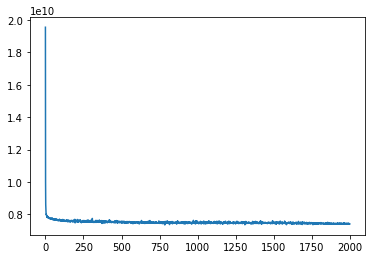

In [107]:
plt.plot(history.epoch, history.history['loss'])
plt.show()

In [114]:
get_embedding_output = K.function([model.layers[1].input],
                                  [model.layers[1].output])
embeddings = get_embedding_output([locations])[0]

In [115]:
embeddings = np.unique(embeddings, axis=0)
embeddings.shape

(354, 5)

In [116]:
tsne = TSNE()

In [117]:
projected_embeddings = tsne.fit_transform(embeddings)

In [121]:
embeddings_data = pd.DataFrame.from_records(
    list(zip(projected_embeddings[:,0], projected_embeddings[:,1], encoder.inverse_transform(locations)))
)
embeddings_data.columns = ['x', 'y', 'name']

embeddings_data = embeddings_data.drop_duplicates()
embeddings_data.shape

(354, 3)

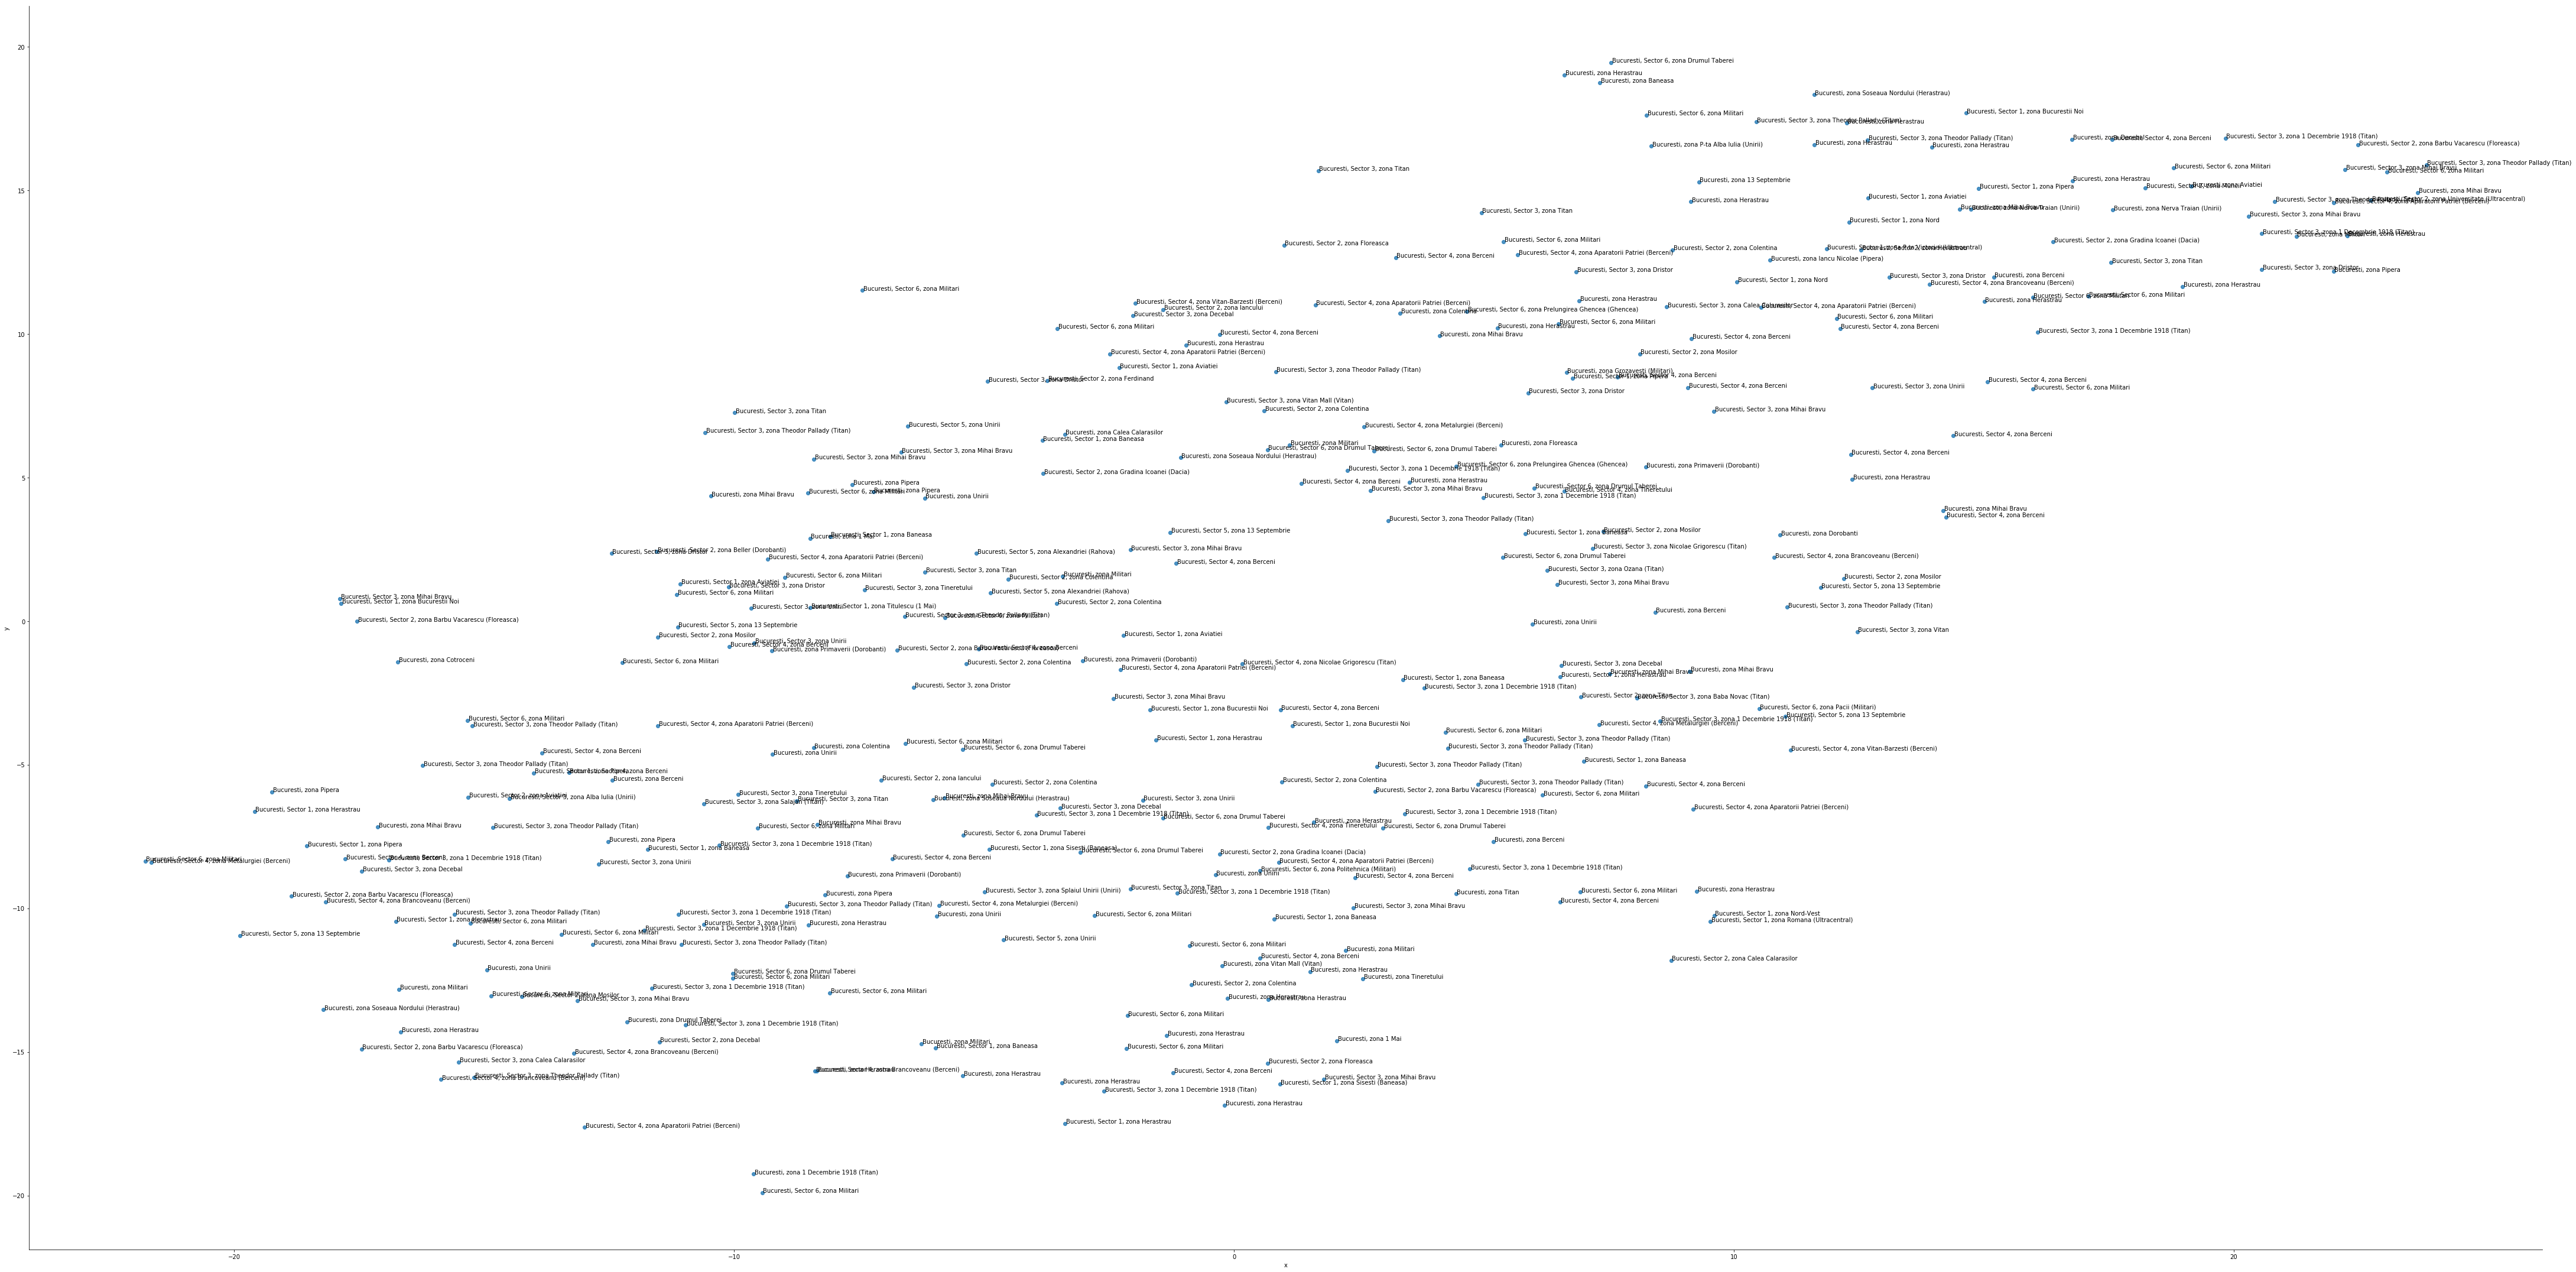

In [122]:
sns.lmplot('x', 'y', data=embeddings_data, fit_reg=False, height=30, aspect=2)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'name': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'] + 0.01, str(point['name']))

label_point(embeddings_data.x, embeddings_data.y, embeddings_data.name, plt.gca())
plt.savefig('location_embeddings_only.png')

### Analyze the price distributions

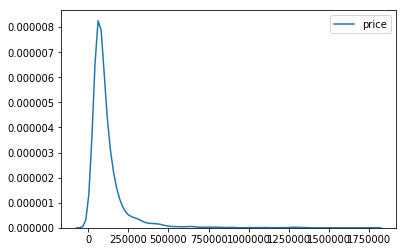

In [151]:
sns.kdeplot(df['price'])

In [152]:
df['price'].describe()

count    3.988000e+03
mean     1.175632e+05
std      1.251538e+05
min      1.000000e+00
25%      5.750000e+04
50%      8.250000e+04
75%      1.295000e+05
max      1.750000e+06
Name: price, dtype: float64

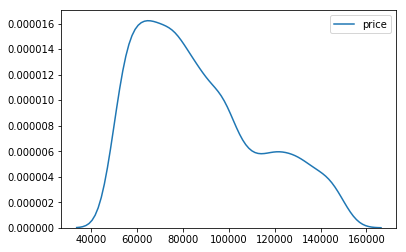

In [153]:
sns.kdeplot(df.loc[df['price'] > 50000].loc[df['price'] < 150000]['price'])

### Make a model using only a 50k-150k price range

In [154]:
X = np.array(df.loc[df['price'] > 50000][df['price'] < 150000][independent_variables])
y = np.array(df.loc[df['price'] > 50000][df['price'] < 150000]['price'])

vectorizer = TfidfVectorizer(min_df=.2, max_df=0.8)
text_data = vectorizer.fit_transform(df.loc[df['price'] > 50000][df['price'] < 150000]['description'])

X = np.hstack([X, text_data.todense()])
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

models = []
kfold = KFold(n_splits=5)

for split, (train_indices, test_indices) in enumerate(kfold.split(range(X.shape[0]))):
    train_X, train_y = X[train_indices], y[train_indices]
    test_X, test_y = X[test_indices], y[test_indices]
    
    model = LinearRegressionTF()
    model.fit(train_X, train_y)
    y_pred = model.predict(test_X)
    score = np.sqrt(mean_squared_error(test_y, y_pred))  # RMSE
    models.append(model)
    print('[Split %d] Score: %f' % (split, score))

/home/rbotarleanu/.conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/rbotarleanu/.conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/rbotarleanu/.conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


[Split 0] Score: 19248.701305
[Split 1] Score: 20308.141000
[Split 2] Score: 18598.890890
[Split 3] Score: 20871.224772
[Split 4] Score: 20663.897025


In [155]:
model = LinearRegressionTF()
model.fit(X, y)

In [156]:
model.coef_, model.intercept_

(<tf.Tensor: id=1149, shape=(113, 1), dtype=float32, numpy=
 array([[  2685.8264  ],
        [  3824.983   ],
        [   614.5025  ],
        [ 10241.017   ],
        [ -1095.6129  ],
        [ -1090.4603  ],
        [  -878.7432  ],
        [ -1876.8531  ],
        [   -63.976738],
        [   652.4559  ],
        [  1104.0842  ],
        [   741.2007  ],
        [   290.6125  ],
        [   424.16742 ],
        [ -1814.9695  ],
        [    58.93261 ],
        [  -882.7091  ],
        [  -791.26575 ],
        [  -161.50446 ],
        [ -1809.0244  ],
        [  -320.48718 ],
        [   272.44275 ],
        [   150.46446 ],
        [   932.49036 ],
        [   412.72998 ],
        [  1855.917   ],
        [  3667.1116  ],
        [  1247.2748  ],
        [  1076.0594  ],
        [  3078.2637  ],
        [  1380.6145  ],
        [  -971.7269  ],
        [ -1068.1401  ],
        [  -922.8135  ],
        [  -761.15314 ],
        [  -885.92334 ],
        [  -368.02026 ],
        [  -729

In [157]:
np.sqrt(mean_squared_error(model.predict(X), y))

18466.649163338432